Epoch 1: train loss=1.4062825098366993, test loss=1.2298762642653884, test acc=55.92%
Epoch 2: train loss=0.8916569246203089, test loss=0.8118645104633015, test acc=71.18%
Epoch 3: train loss=0.6946983007747499, test loss=0.7186683551141411, test acc=76.34%
Epoch 4: train loss=0.5810404637509294, test loss=0.6387052490453052, test acc=78.12%
Epoch 5: train loss=0.5012933648646335, test loss=0.5314276840086956, test acc=82.01%
Epoch 6: train loss=0.4361825277433371, test loss=0.4815298630173799, test acc=83.89%
Epoch 7: train loss=0.3851090403812011, test loss=0.5053369893579726, test acc=83.12%
Epoch 8: train loss=0.34281028708076233, test loss=0.47125341653064556, test acc=84.42%
Epoch 9: train loss=0.2984433954919848, test loss=0.5176479238423572, test acc=84.18%
Epoch 10: train loss=0.2680672392954149, test loss=0.3679890512091339, test acc=87.55%
Epoch 11: train loss=0.23144484263704257, test loss=0.54268428379563, test acc=83.47%
Epoch 12: train loss=0.20861290491964962, test loss

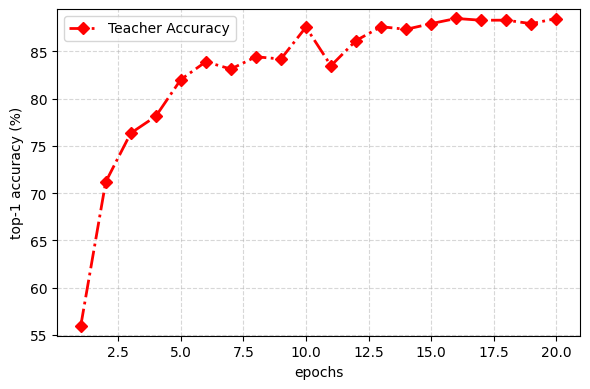

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms import InterpolationMode
from timm.data.random_erasing import RandomErasing
import matplotlib.pyplot as plt
import torch.multiprocessing as mp

mp.set_start_method('spawn', force=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform_train = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    RandomErasing(probability=0.25, mode='const')
])
transform_test = transforms.Compose([
    transforms.Resize(224, interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses, test_accuracies = [], [], []

for epoch in range(1, 21):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    model.eval()
    correct = total = 0
    eval_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_test_loss = eval_loss / len(testloader)
    test_acc = 100 * correct / total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print("Epoch " + str(epoch) + ": train loss=" + str(avg_train_loss) +
          ", test loss=" + str(avg_test_loss) + ", test acc=" + str(test_acc) + "%")

torch.save(model.state_dict(), "resnet18_cifar10_teacher.pth")
print("Model saved as resnet18_cifar10_teacher.pth")


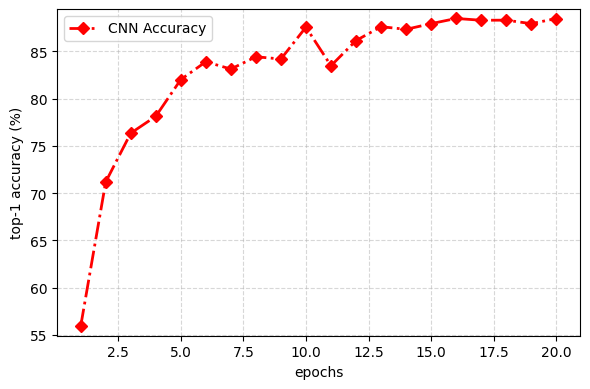

In [4]:
epochs_range = range(1, 21)

plt.figure(figsize=(6, 4))
plt.plot(epochs_range, test_accuracies, color='red', marker='D', linestyle='-.', linewidth=2, label='CNN Accuracy')
plt.xlabel('epochs')
plt.ylabel('top-1 accuracy (%)')
plt.ylim(min(test_accuracies) - 1, max(test_accuracies) + 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()